# Урок 6. Нейросети в обработке текста.
## Домашнее задание
1. Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
TRAIN_DATASET_PATH = 'Twitter_Analysis_train.csv'
TEST_DATASET_PATH = 'Twitter_Analysis_test.csv'

In [10]:
TRAIN_DATASET_PATH = 'D:/task/Twitter_Analysis_train.csv'
TEST_DATASET_PATH = 'D:/task/Twitter_Analysis_test.csv'

In [23]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.tail(10)

,id,label,tweet
31952,31953,0,@user you went too far with @user
31953,31954,0,good morning #instagram #shower #water #berlin...
31954,31955,0,#holiday bull up: you will dominate your bul...
31955,31956,0,less than 2 weeks ð ðð¼ð¹ððµ @us...
31956,31957,0,off fishing tomorrow @user carnt wait first ti...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."
31961,31962,0,thank you @user for you follow


In [24]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.tail()

,id,tweet
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid ð #hairflip #neverre...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."
17196,49159,"my song ""so glad"" free download! #shoegaze ..."


In [14]:
!pip install stop-words pymorphy2

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 55.5/55.5 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 8.2/8.2 MB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32893 sha256=82a6e81c2ce1ef8cbcf8724170bf606c2fc351ff9e3a2cc254c3ca2d3ce5d703
  Stored in directory: c:\users\pochkarenok\appdata\local\pip\cache\wheels\da\d8\66\395317506a23a9d1d7de433ad6a7d9e6e16aab48cf028a0f60
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=f6b6825e6066744a670b0f5f2882a49a46603c5468eae626c5aea01dd3168452
  Stored in directory: c:\users\pochkarenok\appdata\local\pip\cache\wheels\70\4a\46\1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built stop-words docopt


Скачаем библиотеку для лемматизации английских слов:

In [15]:
! pip install spacy
! spacy download en

     ---------------------------------------- 12.2/12.2 MB 8.7 MB/s eta 0:00:00
     ------------------------------------- 483.8/483.8 kB 10.1 MB/s eta 0:00:00
     ------------------------------------- 181.6/181.6 kB 11.4 MB/s eta 0:00:00
     ---------------------------------------- 122.7/122.7 kB ? eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 10.6 MB/s eta 0:00:00
     ---------------------------------------- 45.9/45.9 kB ? eta 0:00:00
     ---------------------------------------- 50.1/50.1 kB ? eta 0:00:00
     ---------------------------------------- 6.6/6.6 MB 11.4 MB/s eta 0:00:00
     ---------------------------------------- 45.0/45.0 kB ? eta 0:00:00
  Attempting uninstall: colorama
    Found existing installation: colorama 0.4.5
    Uninstalling colorama-0.4.5:
      Successfully uninstalled colorama-0.4.5
     --------------------------------------- 12.8/12.8 MB 10.5 MB/s eta 0:00:00
[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use

Установим необходимые библиотеки:

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import spacy
from tqdm import tqdm 
tqdm.pandas()
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")
from nltk.probability import FreqDist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pochkarenok\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [19]:
df_train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

Распределение лейблов очень неравномерное.

Разобьем датасет, используя стратификацию:

In [25]:
df_train, df_val = train_test_split(df_train, test_size=0.3,shuffle=True, random_state=42)

In [26]:
df_train.shape, df_val.shape

((22373, 3), (9589, 3))

Предобработка данных

In [27]:
# Стоп-слово
sw = set(get_stop_words("en"))
sw, len(sw)

({'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  "can't",
  'cannot',
  'could',
  "couldn't",
  'did',
  "didn't",
  'do',
  'does',
  "doesn't",
  'doing',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'had',
  "hadn't",
  'has',
  "hasn't",
  'have',
  "haven't",
  'having',
  'he',
  "he'd",
  "he'll",
  "he's",
  'her',
  'here',
  "here's",
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  "how's",
  'i',
  "i'd",
  "i'll",
  "i'm",
  "i've",
  'if',
  'in',
  'into',
  'is',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  "let's",
  'me',
  'more',
  'most',
  "mustn't",
  'my',
  'myself',
  'no',
  'nor',
  'not',
  'of',
  'off',
  'on',
  'once',
  'only',
  'or',
  'other',
  'ought',
  'our',
  'ours',
  'ourselves',

In [28]:
# Пунктуация
puncts = set(punctuation)
puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [29]:
morpher = MorphAnalyzer()

In [30]:
#Общая функция препроцесса данных
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [39]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("not\s", "not", txt)
    txt = re.sub("dont\s", "dont", txt)
    txt = re.sub("doesnt\s", "doesnt", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [37]:
df_train['tweet'].iloc[:5].values

array(['summer timeð\x9f\x8c\x85 #summeriscoming #swimming #picoftheday #tattoos #issho #pulsera #fluyendo  â\x80¦ ',
       'dese niggas will show dese otha bitches on fb, snap nd twitter more attention then dey do their own girl   but #true ð\x9f\x92¯',
       '"when you are   you boost your immune system and allow your bodies to use the #energy forâ\x80¦ ',
       'reading my manuscript and not wanting to stop.  . good evening and good night. ð\x9f\x98´',
       'baby says he hates me today  '], dtype=object)

In [38]:
df_train['tweet'].iloc[:5].apply(preprocess_text).values

array(['summer timeð\x9f\x8c summeriscoming swimming picoftheday tattoos issho pulsera fluyendo â\x80¦',
       'dese niggas will show dese otha bitches fb snap nd twitter attention dey girl true ð\x9f\x92¯',
       'boost immune system allow bodies use energy forâ\x80¦',
       'reading manuscript notwanting stop good evening good night ð\x9f\x98´',
       'baby says hates today'], dtype=object)

In [40]:
# Преобразование имеющегося текста
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)
df_test['tweet'] = df_test['tweet'].progress_apply(preprocess_text)

100%|██████████| 17197/17197 [00:01<00:00, 10672.94it/s]


In [41]:
# Единый список слов
train_corpus = " ".join(df_train['tweet'])
train_corpus = train_corpus.lower()

In [42]:
# Токенизация
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pochkarenok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['summer', 'timeð\x9f\x8c', 'summeriscoming', 'swimming', 'picoftheday']

In [43]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [45]:
max_words = 2000
max_len = 20
num_classes = 1

In [46]:
epochs = 10
batch_size = 512
print_batch_n = 100

In [47]:
# Словарь
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1999

In [48]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'happy', 'amp', 'just', 'will', 'u', 'im', 'life']

In [49]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

Инициализируем функцию токенизации:

In [50]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [51]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["tweet"]])

Wall time: 2.34 s


In [54]:
df_train['tweet'].iloc[2]

'boost immune system allow bodies use energy forâ\x80¦'

In [56]:
x_train[2]

array([1186, 1291,  364,  756,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

Инициализируем сеть:

In [57]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)
        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

Инициализируем класс датасета:

In [58]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

Инициализируем подготовкy загрузчиков:

In [59]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [60]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 20])
torch.Size([512])
tensor(0)


In [61]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [62]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 346497


In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

Инициализируем обучение модели:

In [64]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

Epoch [1/10]. Step [44/44]. Loss: 0.129. Acc: 0.915. Test loss: 0.011. Test acc: 0.934
Epoch [2/10]. Step [44/44]. Loss: 0.122. Acc: 0.951. Test loss: 0.125. Test acc: 0.948
Epoch [3/10]. Step [44/44]. Loss: 0.130. Acc: 0.966. Test loss: 0.001. Test acc: 0.945
Epoch [4/10]. Step [44/44]. Loss: 0.071. Acc: 0.976. Test loss: 1.064. Test acc: 0.947
Epoch [5/10]. Step [44/44]. Loss: 0.067. Acc: 0.983. Test loss: 0.192. Test acc: 0.941
Epoch [6/10]. Step [44/44]. Loss: 0.048. Acc: 0.989. Test loss: 0.038. Test acc: 0.943
Epoch [7/10]. Step [44/44]. Loss: 0.032. Acc: 0.992. Test loss: 0.562. Test acc: 0.931
Epoch [8/10]. Step [44/44]. Loss: 0.025. Acc: 0.992. Test loss: 0.000. Test acc: 0.942
Epoch [9/10]. Step [44/44]. Loss: 0.021. Acc: 0.991. Test loss: 0.005. Test acc: 0.927
Epoch [10/10]. Step [44/44]. Loss: 0.009. Acc: 0.991. Test loss: 0.575. Test acc: 0.940
Training is finished!


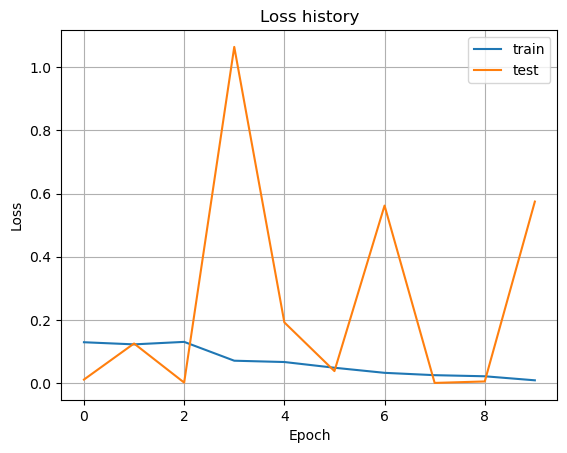

In [65]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

## увеличим количество max_words и max_len

In [66]:
max_words = 3000
max_len = 25
num_classes = 1

model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

Epoch [1/10]. Step [44/44]. Loss: 0.010. Acc: 0.995. Test loss: 0.001. Test acc: 0.937
Epoch [2/10]. Step [44/44]. Loss: 0.019. Acc: 0.997. Test loss: 0.000. Test acc: 0.941
Epoch [3/10]. Step [44/44]. Loss: 0.010. Acc: 0.997. Test loss: 0.004. Test acc: 0.937
Epoch [4/10]. Step [44/44]. Loss: 0.022. Acc: 0.997. Test loss: 0.014. Test acc: 0.938
Epoch [5/10]. Step [44/44]. Loss: 0.015. Acc: 0.997. Test loss: 0.105. Test acc: 0.940
Epoch [6/10]. Step [44/44]. Loss: 0.001. Acc: 0.997. Test loss: 0.017. Test acc: 0.944
Epoch [7/10]. Step [44/44]. Loss: 0.017. Acc: 0.997. Test loss: 0.000. Test acc: 0.937
Epoch [8/10]. Step [44/44]. Loss: 0.025. Acc: 0.997. Test loss: 0.002. Test acc: 0.937
Epoch [9/10]. Step [44/44]. Loss: 0.009. Acc: 0.997. Test loss: 0.000. Test acc: 0.944
Epoch [10/10]. Step [44/44]. Loss: 0.007. Acc: 0.996. Test loss: 0.000. Test acc: 0.939
Training is finished!


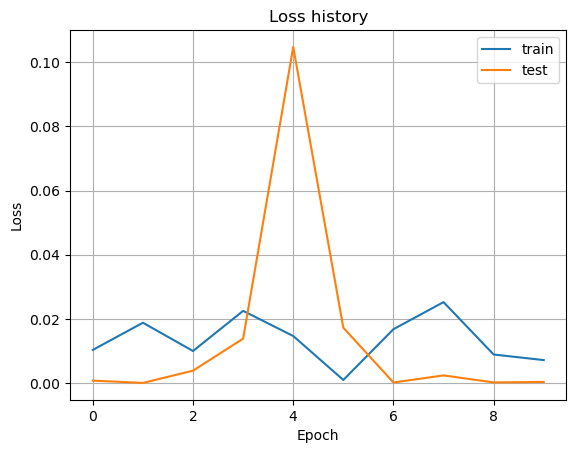

In [67]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

## Добавим в модель дропаут-слои. Инициализируем ее:

In [68]:
class Net2(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(out_channel, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        self.dp1 = nn.Dropout(.4)
        self.dp2 = nn.Dropout(.4)
        self.dp3 = nn.Dropout(.4)
        self.dp4 = nn.Dropout(.4)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L 
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.dp4(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.dp1(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.dp2(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = self.dp3(output)
        output = F.sigmoid(output)
        return output

In [69]:
model = Net2(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [70]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net2(
  (embedding): Embedding(3000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
  (dp1): Dropout(p=0.4, inplace=False)
  (dp2): Dropout(p=0.4, inplace=False)
  (dp3): Dropout(p=0.4, inplace=False)
  (dp4): Dropout(p=0.4, inplace=False)
)
Parameters: 474497


In [71]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [72]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

Epoch [1/10]. Step [44/44]. Loss: 0.468. Acc: 0.926. Test loss: 0.345. Test acc: 0.929
Epoch [2/10]. Step [44/44]. Loss: 0.430. Acc: 0.930. Test loss: 0.264. Test acc: 0.929
Epoch [3/10]. Step [44/44]. Loss: 0.418. Acc: 0.930. Test loss: 0.258. Test acc: 0.932
Epoch [4/10]. Step [44/44]. Loss: 0.395. Acc: 0.934. Test loss: 0.223. Test acc: 0.942
Epoch [5/10]. Step [44/44]. Loss: 0.436. Acc: 0.939. Test loss: 0.091. Test acc: 0.941
Epoch [6/10]. Step [44/44]. Loss: 0.385. Acc: 0.941. Test loss: 0.149. Test acc: 0.945
Epoch [7/10]. Step [44/44]. Loss: 0.370. Acc: 0.945. Test loss: 0.097. Test acc: 0.946
Epoch [8/10]. Step [44/44]. Loss: 0.350. Acc: 0.948. Test loss: 0.143. Test acc: 0.946
Epoch [9/10]. Step [44/44]. Loss: 0.361. Acc: 0.948. Test loss: 0.408. Test acc: 0.946
Epoch [10/10]. Step [44/44]. Loss: 0.335. Acc: 0.949. Test loss: 0.225. Test acc: 0.948
Training is finished!


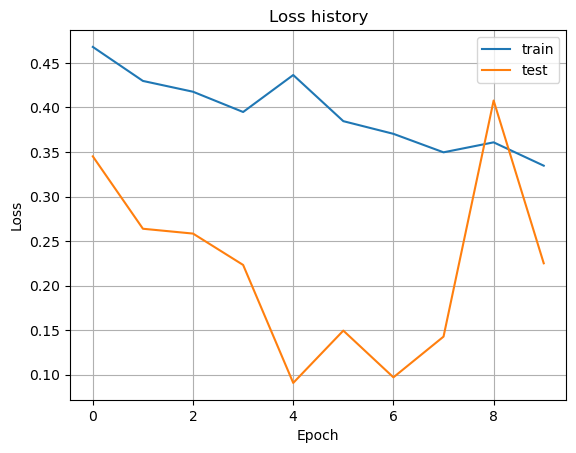

In [74]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

## Вывод:
### Добавление дропаут слоев несколько улучшило метрики, но незначительно. Изменение словаря положительного эффекта не принесло.